<a href="https://colab.research.google.com/github/sSaadhussain02/projects/blob/main/Sentiment_Analysis_Using_CNN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Sentiment_Analysis_Using_CNN-LSTM**

Group Members

*   Saad Hussain cs201116
*   Muhammad Kownain Qadir cs201074
*   Syed Ali Hassan cs201140

In [ ]:
!pip install tensorflow
!pip install keras-pos-embd
!pip install gensim
!pip install smart_open
!pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for keras-pos-embd: filename=keras_pos_embd-0.13.0-py3-none-any.whl size=6946 sha256=7de832dc5e675dccecdaf150cfb9962463a97f39ea8c8b4414856638eafa94bd
  Stored in directory: /root/.cache/pip/wheels/78/07/1b/b1ca47b6ac338554b75c8f52c54e6a2bfbe1b07d79579979a4
Successfully built keras-pos-embd
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt

import seaborn as sns
from wordcloud import WordCloud
%matplotlib inline

from __future__ import division, print_function
from keras.layers import Dense, Dropout, Input, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer

from tensorflow.keras.preprocessing.sequence import pad_sequences

import nltk
nltk.download('punkt')
from nltk import word_tokenize, WordNetLemmatizer
from nltk.corpus import stopwords

from keras.models import Model
from sklearn.model_selection import train_test_split

import re
import string

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## **Data Import**
(Reddit & Twitter data)

In [ ]:
data_twitter=pd.read_csv('/content/Twitter_Data.csv')
data_twitter.head()

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [ ]:
data_reddit=pd.read_csv('/content/Reddit_Data.csv')
data_reddit.head()

,clean_comment,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1


# **Data Information**

In [ ]:
data_twitter.info()

In [ ]:
data_reddit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37249 entries, 0 to 37248
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   clean_comment  37149 non-null  object
 1   category       37249 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 582.1+ KB


In [ ]:
data_twitter.dtypes

clean_text     object
category      float64
dtype: object

In [ ]:
data_reddit.dtypes

clean_comment    object
category          int64
dtype: object

In [ ]:
shape1 = data_twitter.shape

print("Shape of twitter= {}".format(shape1))

shape2 = data_reddit.shape

print("Shape of reddit = {}".format(shape2))

Shape of twitter= (162980, 2)
Shape of reddit = (37249, 2)


In [ ]:
counts = [len(data_reddit), len(data_twitter)]
labels = ['Reddit', 'Twitter']
colors = ['red', 'blue']

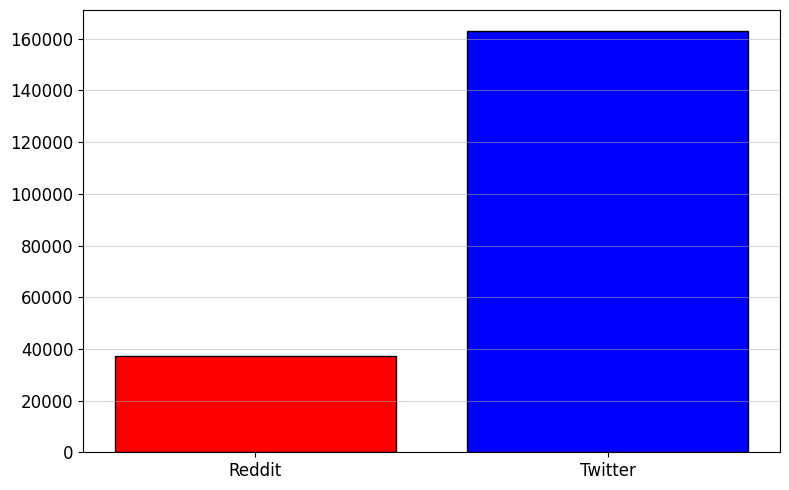

In [ ]:
plt.figure(figsize=(8,5))

plt.bar(labels, counts, color=colors, edgecolor='black')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(axis='y', alpha=0.5)
plt.tight_layout()

## **Data Merging**

In [ ]:
data_reddit.rename(columns={'clean_comment':'comment'}, inplace=True)
data_twitter.rename(columns={'clean_text':'comment'}, inplace=True)


# Concat reddit data and twiter data
concat_df = pd.concat([data_reddit, data_twitter], ignore_index=True)
concat_df.drop_duplicates(subset='comment', keep=False, inplace=True)

In [ ]:
concat_df.head()

,comment,category
0,family mormon have never tried explain them t...,1.0
1,buddhism has very much lot compatible with chr...,1.0
2,seriously don say thing first all they won get...,-1.0
3,what you have learned yours and only yours wha...,0.0
4,for your own benefit you may want read living ...,1.0


In [ ]:
for i in ['1.0', '0.0', '-1.0']:
    concat_df[i] = concat_df['category'].astype(str).apply(lambda x: 1 if i == x else 0)

In [ ]:
concat_df = concat_df.rename(columns={'1.0': 'Pos', '0.0': 'Neu', '-1.0': 'Neg'})

In [ ]:
concat_df

,comment,category,Pos,Neu,Neg
0,family mormon have never tried explain them t...,1.0,1,0,0
1,buddhism has very much lot compatible with chr...,1.0,1,0,0
2,seriously don say thing first all they won get...,-1.0,0,0,1
3,what you have learned yours and only yours wha...,0.0,0,1,0
4,for your own benefit you may want read living ...,1.0,1,0,0
...,...,...,...,...,...
200224,why these 456 crores paid neerav modi not reco...,-1.0,0,0,1
200225,dear rss terrorist payal gawar what about modi...,-1.0,0,0,1
200226,did you cover her interaction forum where she ...,0.0,0,1,0
200227,there big project came into india modi dream p...,0.0,0,1,0


In [ ]:
concat_df.dtypes

comment      object
category    float64
Pos           int64
Neu           int64
Neg           int64
dtype: object

# **DATA PRE-PROCESSING**

## **Data Cleaning**

In [ ]:
def preprocess_comment(comment):
    comment = re.sub('[' + string.punctuation + ']', '', comment)
    tokens = word_tokenize(comment)
    tokens = [w.lower() for w in tokens if w.lower() not in stoplist]
    return ' '.join(tokens)

In [ ]:
import nltk
nltk.download("stopwords")
stoplist = set(stopwords.words('english'))

def removeStopWords(tokens):
    return [word for word in tokens if word not in stoplist]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
concat_df['comment'] = concat_df['comment'].apply(lambda x: preprocess_comment(x))
concat_df['tokens'] = concat_df['comment'].apply(lambda x: word_tokenize(x))
concat_df['tokens'] = concat_df['tokens'].apply(lambda x: [w.lower() for w in x if w.lower() not in stoplist])

In [ ]:
concat_df

,comment,category,Pos,Neu,Neg,tokens
0,family mormon never tried explain still stare ...,1.0,1,0,0,"[family, mormon, never, tried, explain, still,..."
1,buddhism much lot compatible christianity espe...,1.0,1,0,0,"[buddhism, much, lot, compatible, christianity..."
2,seriously say thing first get complex explain ...,-1.0,0,0,1,"[seriously, say, thing, first, get, complex, e..."
3,learned want teach different focus goal wrappi...,0.0,0,1,0,"[learned, want, teach, different, focus, goal,..."
4,benefit may want read living buddha living chr...,1.0,1,0,0,"[benefit, may, want, read, living, buddha, liv..."
...,...,...,...,...,...,...
200224,456 crores paid neerav modi recovered congress...,-1.0,0,0,1,"[456, crores, paid, neerav, modi, recovered, c..."
200225,dear rss terrorist payal gawar modi killing 10...,-1.0,0,0,1,"[dear, rss, terrorist, payal, gawar, modi, kil..."
200226,cover interaction forum left,0.0,0,1,0,"[cover, interaction, forum, left]"
200227,big project came india modi dream project happ...,0.0,0,1,0,"[big, project, came, india, modi, dream, proje..."


# **Data Visualization**

***Size of DataSet after cleaning***

In [ ]:
counts = [len(data_reddit), len(data_twitter), len(concat_df)]
labels = ['Reddit', 'Twitter', 'Total']
colors = ['red', 'blue', 'green']

Exact value of total dataset

In [ ]:
shape = concat_df.shape

print("Shape of DATASET= {}".format(shape))


Shape of DATASET= (199512, 6)


In [ ]:
concat_df.isnull().values.any()

True

In [ ]:
concat_df['comment'].nunique()

195042

In [ ]:
concat_df['category'].nunique()

3

#  **COUNTING COMMENTS ON BASES OF THEIR SENTIMENTS**

*NEGATIVE(-1)  ,    NEUTRAL(0)     ,   POSITIVE(1)*

In [ ]:
negative_count = [len(data_reddit[data_reddit.category == -1]),
                 len(data_twitter[data_twitter.category == -1]),
                 len(concat_df[concat_df.category == -1])]


In [ ]:
neutral_count = [len(data_reddit[data_reddit.category == 0]),
                 len(data_twitter[data_twitter.category == 0]),
                 len(concat_df[concat_df.category == 0])]

In [ ]:
positive_count = [len(data_reddit[data_reddit.category == 1]),
                 len(data_twitter[data_twitter.category == 1]),
                 len(concat_df[concat_df.category == 1])]

In [ ]:
x = ['Reddit', 'Twitter', 'Total']
x_indexes = np.arange(len(x))
width = 0.25

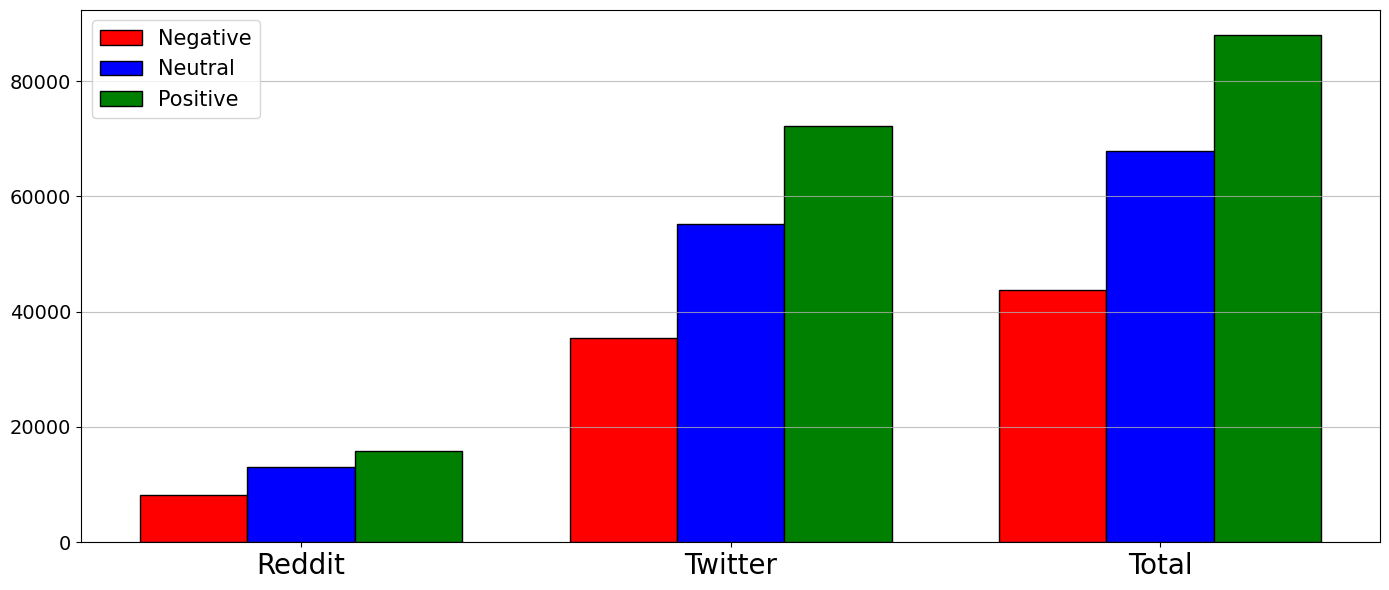

In [ ]:
plt.figure(figsize=(14,6))

plt.bar(x_indexes - width, negative_count, width=width, label='Negative', edgecolor='black', color='red')
plt.bar(x_indexes, neutral_count, width=width, label='Neutral', edgecolor='black', color='blue')
plt.bar(x_indexes + width, positive_count, width=width, label='Positive', edgecolor='black', color='green')

plt.yticks(fontsize=14)
plt.xticks(ticks=x_indexes, labels=x, fontsize=20)

plt.legend(prop={'size':15})
plt.grid(axis='y', alpha=0.77)
plt.tight_layout()

# ***CLOUD OF FREQUENTLY USED WORDS***

*NEGATIVE*

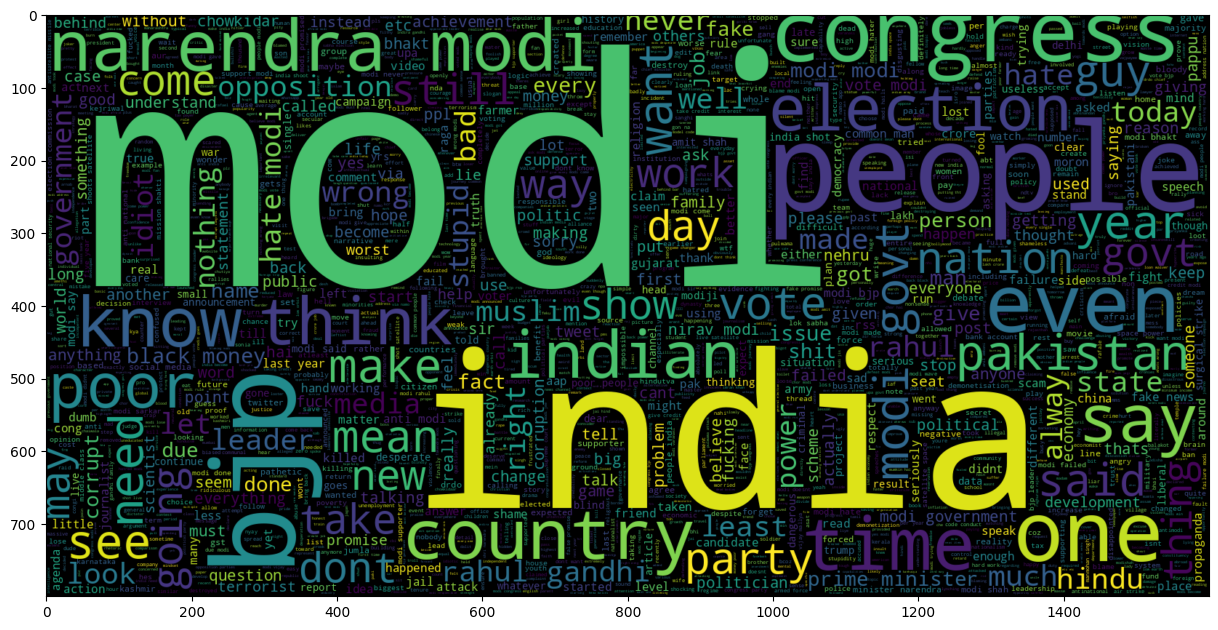

In [ ]:
plt.figure(figsize = (15,15))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(concat_df[concat_df.category == -1].comment))
plt.imshow(wc , interpolation = 'bilinear')

*NEUTRAL*

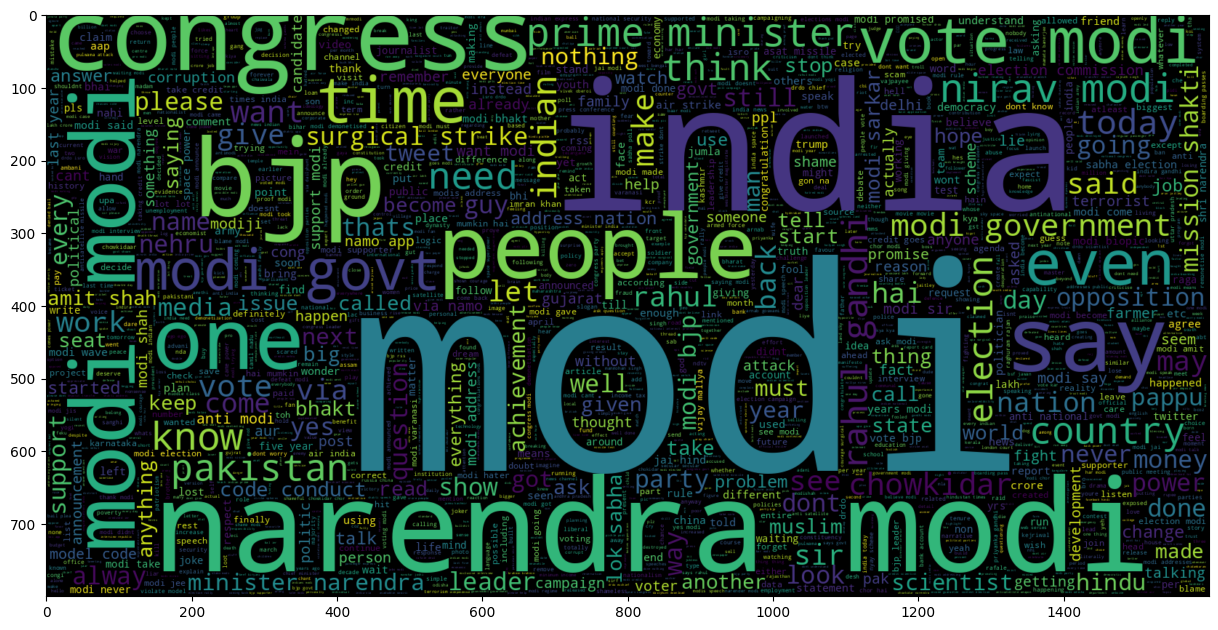

In [ ]:
plt.figure(figsize = (15,15))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(concat_df[concat_df.category == 0].comment))
plt.imshow(wc , interpolation = 'bilinear')

*POSITIVE*

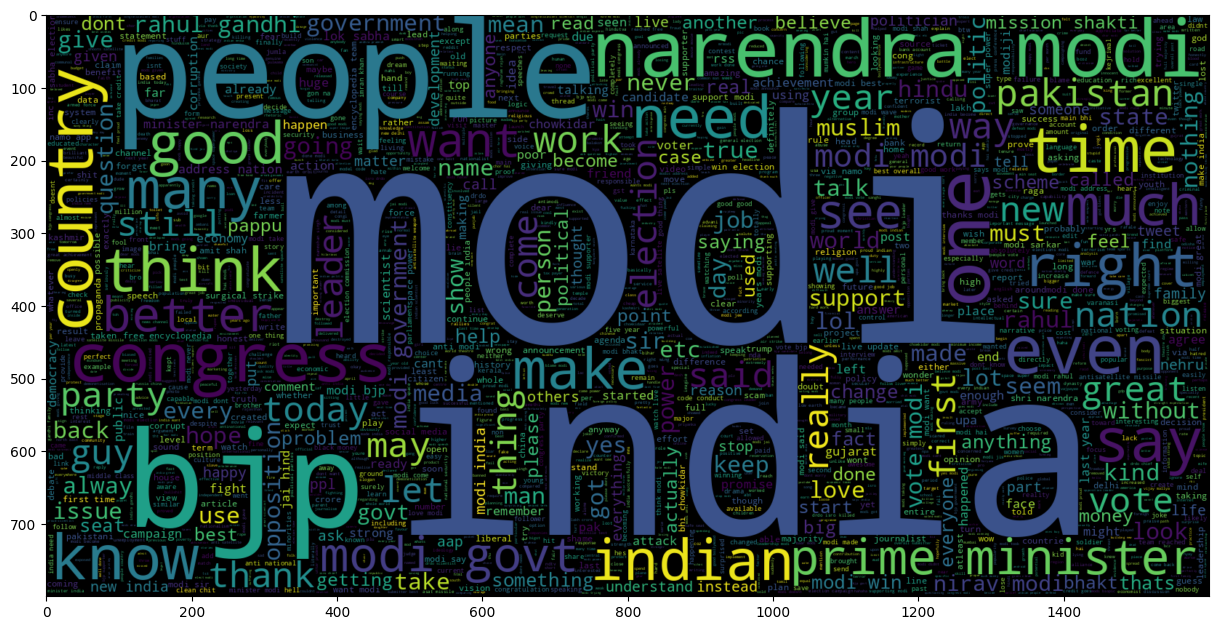

In [ ]:
plt.figure(figsize = (15,15))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(concat_df[concat_df.category == 1].comment))
plt.imshow(wc , interpolation = 'bilinear')

# **SPLITING DATASET**

In [ ]:
data_train, data_test = train_test_split(concat_df, test_size=0.10, random_state=42)

# **EMBADING LAYER**

Total number of words: It counts all the words in the data_train dataset and prints the total count.

Vocabulary size: It determines the unique words in the data_train dataset and prints the count of those unique words.

Maximum sentence length: It calculates the length of each sentence in the data_train dataset and identifies the sentence with the maximum length. It then prints the maximum sentence length.

In [ ]:
all_training_words = [word for tokens in data_train["tokens"] for word in tokens]
training_sentence_lengths = [len(tokens) for tokens in data_train["tokens"]]
TRAINING_VOCAB = sorted(list(set(all_training_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_training_words), len(TRAINING_VOCAB)))
print("Max sentence length is %s" % max(training_sentence_lengths))

2790370 words total, with a vocabulary size of 126015
Max sentence length is 870


In [ ]:
all_test_words = [word for tokens in data_test["tokens"] for word in tokens]
test_sentence_lengths = [len(tokens) for tokens in data_test["tokens"]]
TEST_VOCAB = sorted(list(set(all_test_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_test_words), len(TEST_VOCAB)))
print("Max sentence length is %s" % max(test_sentence_lengths))

305580 words total, with a vocabulary size of 33128
Max sentence length is 784


# **Load Google News Word2Vec model**

In [ ]:
import gensim.downloader as api

wv = api.load('word2vec-google-news-300')

data = wv['king']

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, clean_comments, generate_missing=False):
    embeddings = clean_comments['tokens'].apply(lambda x: get_average_word2vec(x, vectors,
                                                                                generate_missing=generate_missing))
    return list(embeddings)

In [ ]:
training_embeddings = get_word2vec_embeddings(data, data_train, generate_missing=True)

In [ ]:
MAX_SEQUENCE_LENGTH = 128
EMBEDDING_DIM = 300

**Tokeniozer and padsequence**

In [ ]:
tokenizer = Tokenizer(num_words=len(TRAINING_VOCAB), lower=True, char_level=False)
tokenizer.fit_on_texts(data_train["comment"].tolist())
training_sequences = tokenizer.texts_to_sequences(data_train["comment"].tolist())

train_word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(train_word_index))

Found 125943 unique tokens.


In [ ]:
train_cnn_data = pad_sequences(training_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [ ]:
train_embedding_weights = np.zeros((len(train_word_index)+1, EMBEDDING_DIM))
for word,index in train_word_index.items():
    train_embedding_weights[index,:] = data[word] if word in data else np.random.rand(EMBEDDING_DIM)
print(train_embedding_weights.shape)

(125944, 300)


In [ ]:
test_sequences = tokenizer.texts_to_sequences(data_test["comment"].tolist())
test_cnn_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

# **CNN-LSTM**

An LSTM is a type of recurrent neural network (RNN) that can capture long-term dependencies in sequential data.

In [ ]:
label_names = ['Pos', 'Neu', 'Neg']

In [ ]:
y_train = data_train[label_names].values

In [ ]:
x_train = train_cnn_data

In [ ]:
def ConvNet(embeddings, max_sequence_length, num_words, embedding_dim, labels_index):

    embedding_layer = Embedding(num_words,
                            embedding_dim,
                            weights=[embeddings],
                            input_length=max_sequence_length,
                            trainable=False)

    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

#     lstm = LSTM(256, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)(embedded_sequences)

    lstm = LSTM(256)(embedded_sequences) #  This layer processes the sequential input data and captures the contextual information.


# This dense layer performs a linear transformation on the LSTM output and applies the ReLU activation function, which introduces non-linearity to the network.
    x = Dense(128, activation='relu')(lstm)

    x = Dropout(0.2)(x)

#     To prevent overfitting, a dropout layer with a dropout rate of 0.2 is applied to the output of the dense layer.

#     a dense layer with labels_index units and sigmoid activation function is added to produce the final output predictions.
    preds = Dense(labels_index, activation='sigmoid')(x)

    model = Model(sequence_input, preds)
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])




#     compiles the model by configuring the loss function, optimizer, and evaluation metrics.


#     model summary is printed.

    model.summary()
    return model

In [ ]:
model = ConvNet(train_embedding_weights, MAX_SEQUENCE_LENGTH, len(train_word_index)+1, EMBEDDING_DIM,
                len(list(label_names)))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128)]             0         
                                                                 
 embedding (Embedding)       (None, 128, 300)          37783200  
                                                                 
 lstm (LSTM)                 (None, 256)               570368    
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 38,386,851
Trainable params: 603,651
Non-traina

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


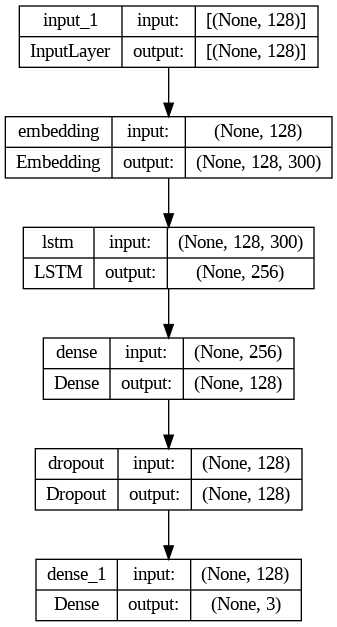

In [ ]:
!pip install pydotplus

from tensorflow import keras
from keras.utils.vis_utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
num_epochs = 10
batch_size = 100

In [ ]:
hist = model.fit(x_train, y_train, epochs=num_epochs, validation_split=0.2, shuffle=True, batch_size=batch_size)

Epoch 1/10
1437/1437 [==============================] - 47s 26ms/step - loss: 0.5548 - acc: 0.5562 - val_loss: 0.4926 - val_acc: 0.6136
Epoch 2/10
1437/1437 [==============================] - 32s 23ms/step - loss: 0.4545 - acc: 0.6594 - val_loss: 0.4096 - val_acc: 0.7096
Epoch 3/10
1437/1437 [==============================] - 34s 23ms/step - loss: 0.3894 - acc: 0.7334 - val_loss: 0.3629 - val_acc: 0.7589
Epoch 4/10
1437/1437 [==============================] - 31s 21ms/step - loss: 0.3527 - acc: 0.7718 - val_loss: 0.3339 - val_acc: 0.7880
Epoch 5/10
1437/1437 [==============================] - 34s 23ms/step - loss: 0.3285 - acc: 0.7951 - val_loss: 0.3254 - val_acc: 0.8017
Epoch 6/10
1437/1437 [==============================] - 34s 24ms/step - loss: 0.3107 - acc: 0.8120 - val_loss: 0.3063 - val_acc: 0.8182
Epoch 7/10
1437/1437 [==============================] - 34s 24ms/step - loss: 0.2937 - acc: 0.8273 - val_loss: 0.2880 - val_acc: 0.8349
Epoch 8/10
1437/1437 [==========================

In [ ]:
predictions = model.predict(test_cnn_data, batch_size=1024, verbose=1)

20/20 [==============================] - 2s 50ms/step


In [ ]:
labels = [1, 0,-1]

In [ ]:
prediction_labels=[]
for p in predictions:
    prediction_labels.append(labels[np.argmax(p)])

In [ ]:
sum(data_test.category==prediction_labels)/len(prediction_labels)*100

84.12189254210104

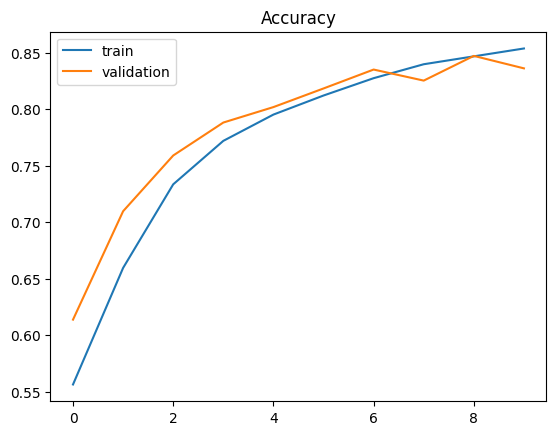

In [ ]:
plt.title('Accuracy')
plt.plot(hist.history['acc'], label='train')
plt.plot(hist.history['val_acc'], label='validation')
plt.legend()
plt.show();

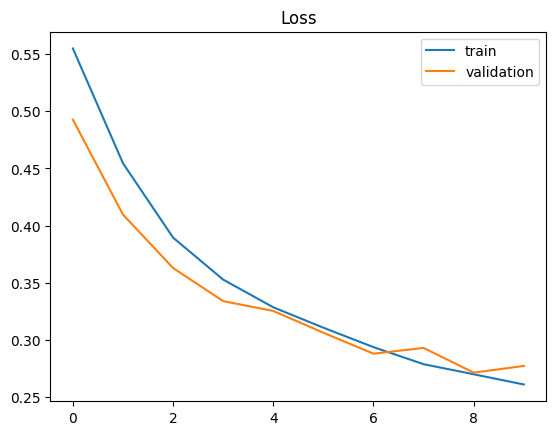

In [ ]:
plt.title('Loss')
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.legend()
plt.show();